# Time Series Analysis: Controlling for Seasonality and Auto-correlation

In [1]:
!pip install dataretrieval

Load data from the Turkey River in Garber, Iowa. This is USGS site [05412500](https://waterdata.usgs.gov/nwis/inventory?site_no=05412500&agency_cd=USGS), which has data from Aug 8, 1913 to the present.

In [2]:
import pandas as pd
import numpy as np
import dataretrieval.nwis as nwis

flow_df = nwis.get_record(sites='05412500', service='dv', parameterCd='00060', start='1913-10-01', end='2024-09-30') # Turkey River at Garber, IA
flow_df.head()

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
1913-10-01 00:00:00+00:00,05412500,480.0,A
1913-10-02 00:00:00+00:00,05412500,325.0,A
1913-10-03 00:00:00+00:00,05412500,265.0,A
1913-10-04 00:00:00+00:00,05412500,208.0,A
1913-10-05 00:00:00+00:00,05412500,680.0,A


Plot the data

<Axes: xlabel='datetime'>

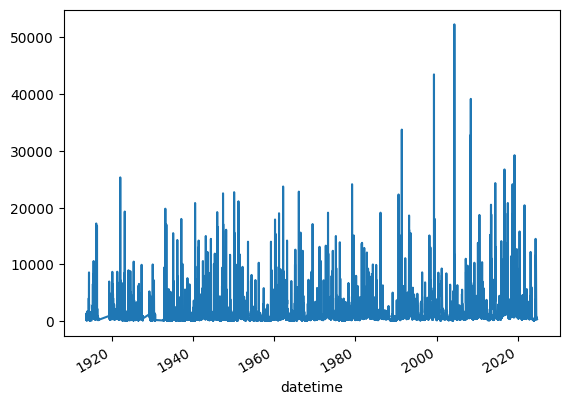

In [3]:
flow_df["00060_Mean"].plot()

There are clearly periods of missing data, which is a problem for time series analysis. These periods are too long to simply interpolate, so we will start our analysis after their is a consistent record. What are the missing periods?

In [4]:
flow_df["00060_Mean"].isna().any()

False

In [5]:
flow_df["00060_Mean"].isnull().any()

False

It's not that the data is NA or null, the dates are just missing.

In [6]:
dates  = pd.date_range(start=flow_df.index.min(), end=flow_df.index.max())
len(dates)

40543

In [7]:
len(flow_df.index)

38345

Find which dates are missing.

In [8]:
dates[np.where(dates.isin(flow_df.index) == False)[0]]

DatetimeIndex(['1916-12-01 00:00:00+00:00', '1916-12-02 00:00:00+00:00',
               '1916-12-03 00:00:00+00:00', '1916-12-04 00:00:00+00:00',
               '1916-12-05 00:00:00+00:00', '1916-12-06 00:00:00+00:00',
               '1916-12-07 00:00:00+00:00', '1916-12-08 00:00:00+00:00',
               '1916-12-09 00:00:00+00:00', '1916-12-10 00:00:00+00:00',
               ...
               '1932-09-21 00:00:00+00:00', '1932-09-22 00:00:00+00:00',
               '1932-09-23 00:00:00+00:00', '1932-09-24 00:00:00+00:00',
               '1932-09-25 00:00:00+00:00', '1932-09-26 00:00:00+00:00',
               '1932-09-27 00:00:00+00:00', '1932-09-28 00:00:00+00:00',
               '1932-09-29 00:00:00+00:00', '1932-09-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=2198, freq=None)

The data is complete after 1932-10-1, so we'll start there.

In [9]:
flow_df = flow_df.loc["1932-10-01":]
flow_df.head()

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
1932-10-01 00:00:00+00:00,05412500,150.0,A
1932-10-02 00:00:00+00:00,05412500,150.0,A
1932-10-03 00:00:00+00:00,05412500,185.0,A
1932-10-04 00:00:00+00:00,05412500,185.0,A
1932-10-05 00:00:00+00:00,05412500,143.0,A


Test if data is normally distributed.

In [10]:
!pip install lmoments3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.3 MB/s eta 0:00:00


In [11]:
from google.colab import drive

# allow access to google drive
drive.mount('/content/drive')

!cp "drive/MyDrive/Colab Notebooks/CE6280/CodingExamples/utils.py" .
from utils import *

Mounted at /content/drive


In [12]:
import scipy.stats as ss
import matplotlib.pyplot as plt
from lmoments3 import distr

class Normal(Distribution):
  def __init__(self):
    super().__init__()
    self.mu = None
    self.sigma = None

  def fit(self, data, method):
    assert method == 'MLE' or method == 'MOM' or method == 'Lmom',"method must = 'MLE', 'MOM' or 'Lmom'"

    self.findMoments(data)
    if method == 'MLE':
      self.mu, self.sigma = ss.norm.fit(data)
    elif method == 'MOM':
      self.mu = self.xbar
      self.sigma = np.sqrt(self.var)
    elif method == 'Lmom':
      norm_params = distr.nor.lmom_fit(data)
      self.mu = norm_params["loc"]
      self.sigma = norm_params["scale"]

  def findReturnPd(self, T):
    q_T = ss.norm.ppf(1-1/T, self.mu, self.sigma)
    return q_T

  def plotHistPDF(self, data, min, max, title):
    x = np.arange(min, max,(max-min)/100)
    f_x = ss.lognorm.pdf(x, self.mu, self.sigma)
    self.plotDistFit(data, x, f_x, min, max, title)

  def ppccTest(self, data, title, m=10000):
    # calculate test statistic, rho
    x_sorted = np.sort(data)
    p_observed = ss.mstats.plotting_positions(x_sorted)
    x_fitted = ss.norm.ppf(p_observed, self.mu, self.sigma)
    self.ppcc_rho = np.corrcoef(x_sorted, x_fitted)[0,1]

    # generate m synthetic samples of n observations to estimate null distribution of rho
    rhoVector = np.zeros(m)
    for i in range(m):
      np.random.seed(i)
      x = ss.norm.rvs(self.mu, self.sigma, size=len(data))
      rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0,1]

    # calculate p-value of test and make QQ plot
    count = 0
    for i in range(len(rhoVector)):
      if self.ppcc_rho < rhoVector[i]:
        count = count + 1

    self.p_value_PPCC = 1 - count/(len(rhoVector) + 1)

    # make Q-Q plot
    plt.scatter(x_sorted,x_fitted,color='b')
    plt.plot(x_sorted,x_sorted,color='r')
    plt.xlabel('Observations')
    plt.ylabel('Fitted Values')
    plt.title(title)
    plt.show()

  def calcCI(self, data, p, CI, method, npars, seed):
    n = len(data)
    alpha = (100.0-CI)/100.0
    # calculate theoretical confidence interval using formula from slides
    z_p = ss.norm.ppf(p)
    z_crit = ss.norm.ppf(1-alpha/2)
    x_p = self.mu + z_p*self.sigma
    LB = x_p - z_crit * np.sqrt(self.sigma**2 * (1+0.5*z_p**2)/n)
    UB = x_p + z_crit * np.sqrt(self.sigma**2 * (1+0.5*z_p**2)/n)
    return LB, UB

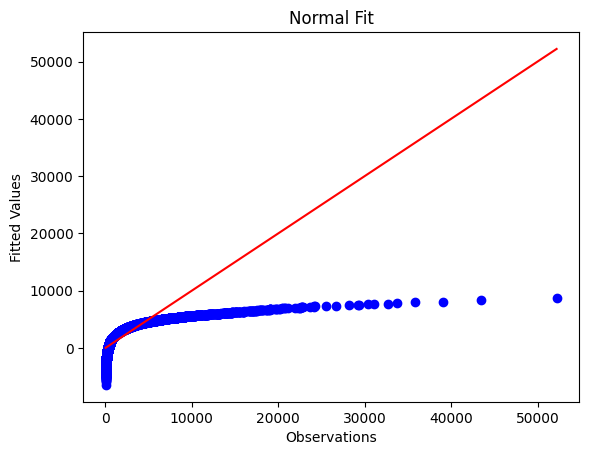

9.999000099991662e-05

In [13]:
dist = Normal()
dist.fit(flow_df["00060_Mean"], "MLE")
dist.ppccTest(flow_df["00060_Mean"], "Normal Fit")
dist.p_value_PPCC

Clearly, the fit is terrible! Let's try a Box-Cox transformation.

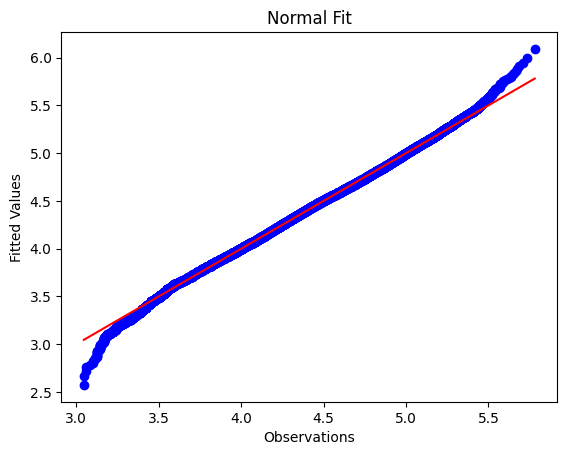

9.999000099991662e-05

In [14]:
flow_df["Q_transformed"], boxcox_power = ss.boxcox(flow_df["00060_Mean"])

dist = Normal()
dist.fit(flow_df["Q_transformed"], "MLE")
dist.ppccTest(flow_df["Q_transformed"], "Normal Fit")
dist.p_value_PPCC

We still reject, but it's much better, so we'll use this moving forward. Below we plot this transformed time series.

<Axes: xlabel='datetime'>

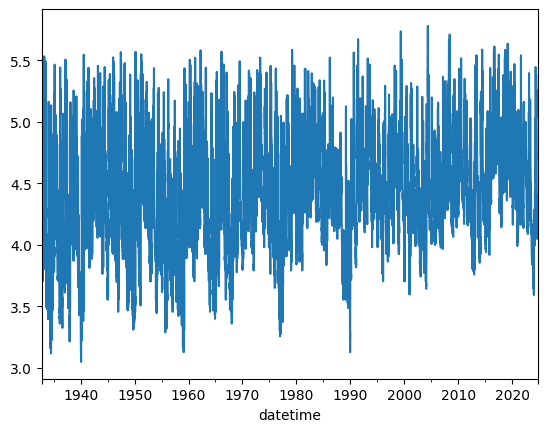

In [37]:
flow_df["Q_transformed"].plot()

It looks like it might have an increasing trend, but first let's remove seasonality and auto-correlation. We'll start by looking for seasonality in the transformed time series with the periodogram.

Text(0, 0.5, 'Amplitude Squared')

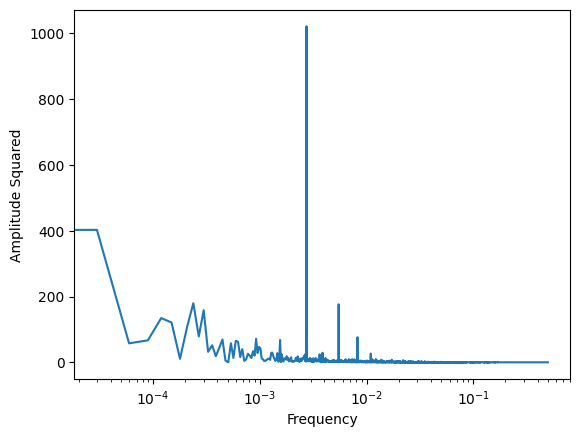

In [15]:
from scipy.signal import periodogram

f, P = periodogram(flow_df["Q_transformed"])
plt.semilogx(f, P)
plt.xlabel('Frequency')
plt.ylabel('Amplitude Squared')

We can clearly see periodicity associated with the annual cycle and its harmonics.

Text(0, 0.5, 'Amplitude Squared')

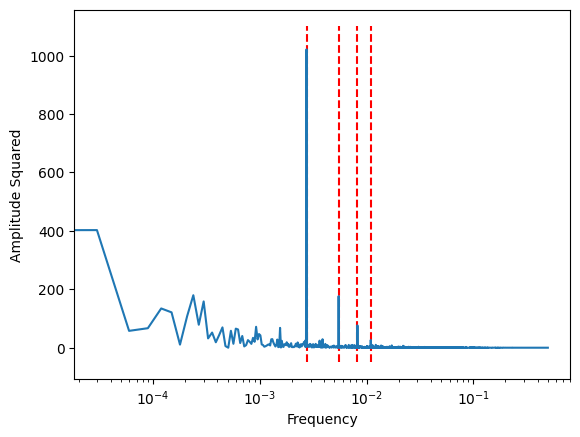

In [16]:
plt.plot([1/365.25, 1/365.25],[-50,1100],color='r',linestyle="--")
plt.plot([2/365.25, 2/365.25],[-50,1100],color='r',linestyle="--")
plt.plot([3/365.25, 3/365.25],[-50,1100],color='r',linestyle="--")
plt.plot([4/365.25, 4/365.25],[-50,1100],color='r',linestyle="--")
plt.semilogx(f, P)
plt.xlabel('Frequency')
plt.ylabel('Amplitude Squared')

The first three are fairly significant, but the fourth is within the noise of other peaks. So let's just include three harmonics in our regression model.  
There are multiple ways you can set up an OLS regression in Python. We'll use notation similar to R here where you pass a formula: `y ~ x1 + x2 + ...` where `y` is the response variable and the terms after the tilde are the predictors, all of which have to be in the same data frame.

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# add columns for time (which we'll later use to test for a trend)
# and the first three harmonics of annual seasonality
flow_df['t'] = np.arange(len(flow_df.index))
for i in range(3):
  flow_df['sine' + str(i+1)] = np.sin(2*np.pi*(i+1)*flow_df['t']/365.25)
  flow_df['cosine' + str(i+1)] = np.cos(2*np.pi*(i+1)*flow_df['t']/365.25)

season_model = smf.ols(formula="Q_transformed ~  sine1 + cosine1 + sine2 + cosine2 + sine3 + cosine3", data=flow_df)
season_result = season_model.fit()
print(season_result.summary())

                            OLS Regression Results                            
Dep. Variable:          Q_transformed   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     1483.
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                        03:19:37   Log-Likelihood:                -15016.
No. Observations:               33603   AIC:                         3.005e+04
Df Residuals:                   33596   BIC:                         3.010e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3328      0.002   2099.315      0.0

All predictors and the model are statistically significant.  

Now check to see if we have "removed" seasonality by looking at the periodogram of the residuals.

Text(0, 0.5, 'Amplitude Squared')

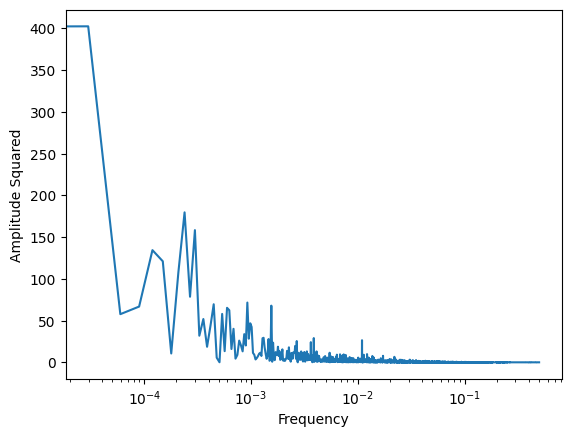

In [18]:
f, P = periodogram(season_result.resid)
plt.semilogx(f, P)
plt.xlabel('Frequency')
plt.ylabel('Amplitude Squared')

The only peaks that stand out now correspond to lower frequencies, which we might be able to capture with autocorrelation, so we'll model that next with ARIMA models. First, let's see what our new time series looks like after removing seasonality.

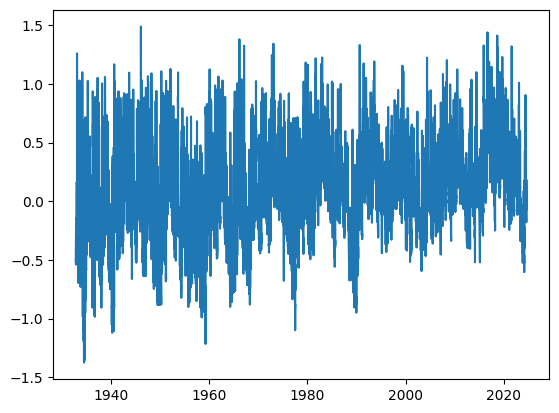

In [38]:
plt.plot(season_result.resid)

Modeling seasonality didn't change the appearance much. It still looks liek there might be a trend, but let's see if that could be from auto-correlation.  
To hypothesize an appropriate ARMA model, let's look at the ACF and PACF of the new time series.

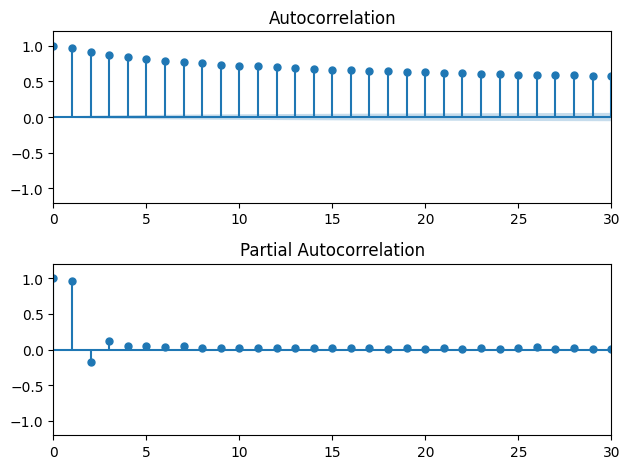

In [19]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
sm.graphics.tsa.plot_acf(season_result.resid, ax=ax)
ax.set_xlim([0,30])
ax.set_ylim([-1.2,1.2])

ax = fig.add_subplot(2,1,2)
sm.graphics.tsa.plot_pacf(season_result.resid, ax=ax)
ax.set_xlim([0,30])
ax.set_ylim([-1.2,1.2])

fig.tight_layout()
fig.show()

An AR(1) model may be appropriate, as the ACF seems to decay exponentially and only the first lag is very significant in the PACF. Let's see if an AR(1) model sufficiently captures the auto-correlation.

In [20]:
from statsmodels.tsa.ar_model import AutoReg

AR1model = AutoReg(season_result.resid, lags=1)
AR1result = AR1model.fit()
print(AR1result.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                33603
Model:                     AutoReg(1)   Log Likelihood               28347.612
Method:               Conditional MLE   S.D. of innovations              0.104
Date:                Wed, 26 Feb 2025   AIC                         -56689.224
Time:                        03:19:38   BIC                         -56663.957
Sample:                    10-02-1932   HQIC                        -56681.160
                         - 09-30-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.394e-05      0.001      0.025      0.980      -0.001       0.001
y.L1           0.9614      0.002    640.522      0.000       0.958       0.964
                                    Roots           

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


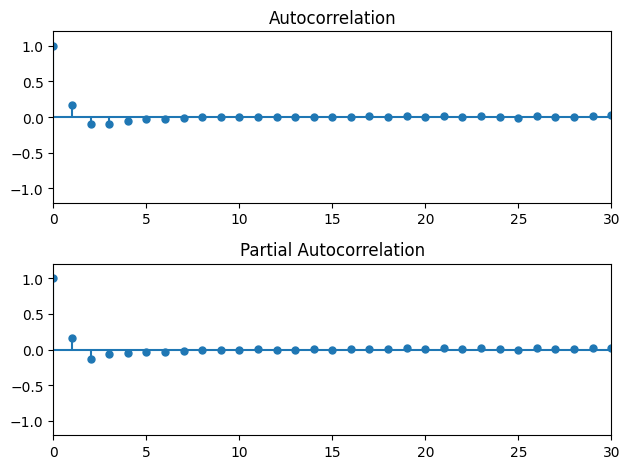

In [21]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
sm.graphics.tsa.plot_acf(AR1result.resid, ax=ax)
ax.set_xlim([0,30])
ax.set_ylim([-1.2,1.2])

ax = fig.add_subplot(2,1,2)
sm.graphics.tsa.plot_pacf(AR1result.resid, ax=ax)
ax.set_xlim([0,30])
ax.set_ylim([-1.2,1.2])

fig.tight_layout()
fig.show()

This seems to have removed most of the auto-correlation!  

For comparison, we can also use automated selection with the [auto.arima function](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA) in the [pmdarima](https://pypi.org/project/pmdarima/) library, but that can be slow for large datasets, so we'll reserve an example for a different time series and stick with the simple AR(1) model for now since it seems to do well.  

Because we've removed seasonality and auto-correlation, we can now test for a trend in the residuals. Let's look at the time series we're modeling now.

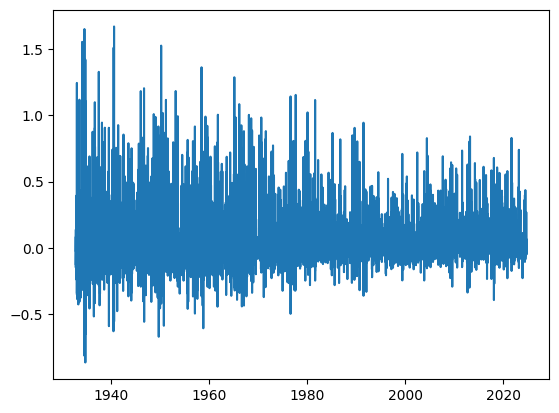

In [39]:
plt.plot(AR1result.resid)

Removing auto-correlation greatly changed the look of the time series! Now it's not very clear if there is a trend in the mean, although there does seem to be a decrease in variability.  

To test for a trend in this time series, we'll build an OLS model to the residuals of the AR(1) model with time as a predictor. Below we use matrix notation instead of R's formula notation.

In [22]:
X = np.array([np.ones(len(AR1result.resid)), range(len(AR1result.resid))]).T
y = AR1result.resid

trend_model = sm.OLS(y, X)
trend_result = trend_model.fit()
print(trend_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     83.62
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           6.32e-20
Time:                        03:19:39   Log-Likelihood:                 28389.
No. Observations:               33602   AIC:                        -5.677e+04
Df Residuals:                   33600   BIC:                        -5.676e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0090      0.001     -7.919      0.0

There is a statistically significant positive trend, though it is slight. What does it look like?

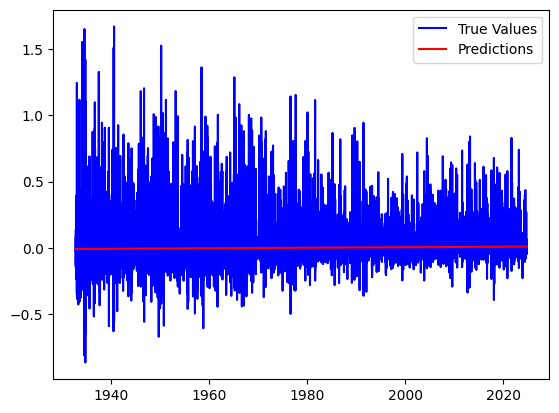

In [41]:
l1, = plt.plot(AR1result.resid, color="blue")
l2, = plt.plot(trend_result.fittedvalues, color="red")
plt.legend([l1,l2],['True Values','Predictions'], loc='upper right')

Clearly the trend is small in magnitude, even if it is statistically significant!  

For perspective, let's convert this daily trend back to real-space and see how many cfs it corresponds to every 365.25 days (year) for the average flow value. Note, because the Box-Cox transformation is non-linear, the trend in real-space is also nonlinear and therefore depends on the flow. For greater interpretability, we can compute that increase as a percentage of the average daily flow.  

Remember the formula for a Box-Cox transformation of $Q$ to $Q_T$:

$$Q_T = \frac{Q^\lambda - 1}{\lambda}$$  
$$Q_T = \frac{1}{\lambda}Q^\lambda - \frac{1}{\lambda}$$

We calculated the slope of this Box-Cox transformed value over time, $\frac{\partial Q_T}{\partial t}$ with our OLS model above. We can convert that to the slope of the real-space values over time, $\frac{\partial Q}{\partial t}$, using calculus:  

$$\frac{\partial Q_T}{\partial t} = Q^{\lambda-1}\frac{\partial Q}{\partial t}$$  
$$\frac{\partial Q}{\partial t} = Q^{1-\lambda}\frac{\partial Q_T}{\partial t}$$  

As you can see, the slope in real space depends on the value of the flow $Q$, making it nonlinear. We'll plug in the average flow $\bar{Q}$ for $Q$, yielding a real-space slope for the mean daily flow of:  

$$\frac{\partial Q}{\partial t} = \bar{Q}^{1-\lambda}\frac{\partial Q_T}{\partial t}$$.

In [36]:
# average increase in transformed daily flow per year
slope_per_year = trend_result.params["x1"]*365.25

# transform back to real-space for the mean daily flow
slope_per_year = np.mean(flow_df["00060_Mean"])**(1-boxcox_power) * slope_per_year

# calculate this as a percentage of the mean daily flow
percent_per_year = 100*slope_per_year/np.mean(flow_df["00060_Mean"])

print("Trend in average daily flow evaluated at the mean flow: %0.2f cfs/year" % slope_per_year)
print("This is %0.2f%% of the mean daily flow" % percent_per_year)

Trend in average daily flow evaluated at the mean flow: 0.57 cfs/year
This is 0.05% of the mean daily flow
